# EasyMLP: Some Simple Examples

## Imports

In [1]:
!pip install easy-mlp
!pip install torch
!pip install numpy
!pip install pretty-plotly
!pip install scikit-learn

In [2]:
from easy_mlp.models import MLP
from easy_mlp.trainers import MLPTrainer
from easy_mlp.data import get_tensors, get_data_loaders
from easy_mlp.helpers import get_loss_fn, get_optimiser, param_init

import torch
import numpy as np
import pretty_plotly.plot as pp
from sklearn.datasets import load_digits, load_breast_cancer, fetch_california_housing, make_classification, make_regression
from sklearn.model_selection import train_test_split

## Set Device

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

device

device(type='mps')

## Regression

### Data Loading and Preprocessing

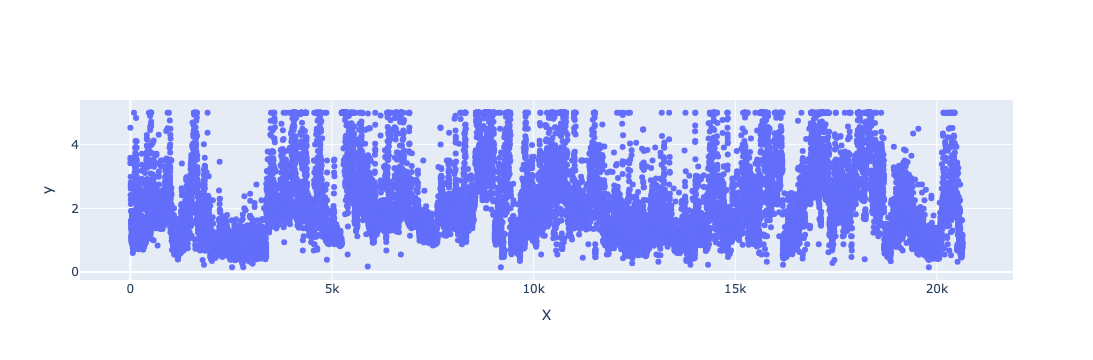

In [4]:
# Get California Housing Data
X, y = fetch_california_housing(return_X_y=True)
x = np.arange(0, y.shape[0])
pp.plot_data(x, y, x_label="X", y_label="y")

# # Generate random data
# X, y = make_regression(n_samples=5000, n_features=50, n_informative=25)
# x = np.arange(0, y.shape[0])
# pp.plot_data(x, y, x_label="X", y_label="y")

In [5]:
# Dataloading parameters
batch_size = 8
test_size = 0.2
val_size = 0.2

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=42)

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (13209, 8)
y_train: (13209,)
X_val: (3303, 8)
y_val: (3303,)
X_test: (4128, 8)
y_test: (4128,)


In [6]:
# Get tensors and dataloaders
X_train, y_train, X_val, y_val = get_tensors(X_train, y_train, X_val, y_val)
train_loader, val_loader = get_data_loaders(X_train, y_train, X_val, y_val, batch_size)

### Building the Model

In [7]:
# Training parameters
num_train_epochs = 20
l_rate = 1e-03
loss_choice = "mse"
optim_choice = "adam"

# Create configuration for model layers
layer_config_1 = [ # a simple linear regression model (a perceptron with no activation)
    (X_train.shape[1], None, None),
    (1, None, None),
]

layer_config_2 = [ # a multi-layer perceptron
    (X_train.shape[1], None, None),
    (200, "relu", None),
    (300, "relu", None),
    (400, "relu", 0.1),
    (200, "relu", None),
    (1, None, None),
]

# Initialise model
reg_model = MLP(layer_config=layer_config_2, model_name="RegModel")
reg_model.set_model_layers()

# Initialise model parameters
reg_model.apply(lambda m: param_init(m, "xavier"))

# Move model to selected device
reg_model.to(device)

print(reg_model)
print(f"Number of trainable parameters: {sum(p.numel() for p in reg_model.parameters())}")

MLP(
  (model): ModuleList(
    (0): Linear(in_features=8, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=400, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.1, inplace=False)
    (7): Linear(in_features=400, out_features=200, bias=True)
    (8): ReLU()
    (9): Linear(in_features=200, out_features=1, bias=True)
  )
)
Number of trainable parameters: 262901


### Training the Model

#### Loss Function and Optimiser

In [8]:
loss_fn = get_loss_fn(loss_choice)  # Mean-square error loss because this a regression task
optimiser = get_optimiser(optim_choice, reg_model, l_rate) # adam

#### Training Loop

In [9]:
reg_trainer = MLPTrainer(type="reg", is_multiclass=False)

reg_trainer.train(
    reg_model,
    num_train_epochs,
    optimiser,
    loss_fn,
    train_loader,
    val_loader,
    device=device,
)

    |                       TRAINING SET                       ||                      VALIDATION SET                      |
    |   Loss   ||   RMSE   ||   MSE    ||   MAE    ||    R2    ||   Loss   ||   RMSE   ||   MSE    ||   MAE    ||    R2    |
001 | 4.17e+02 || 7.23e+00 || 5.22e+01 || 2.08e+00 ||-3.84e+01 || 1.31e+00 || 1.14e+00 || 1.31e+00 || 9.48e-01 || 5.29e-02 |
002 | 9.89e+00 || 1.11e+00 || 1.24e+00 || 8.63e-01 || 6.68e-02 || 1.23e+00 || 1.11e+00 || 1.23e+00 || 8.00e-01 || 1.07e-01 |
003 | 1.17e+01 || 1.21e+00 || 1.47e+00 || 8.57e-01 ||-1.08e-01 || 7.60e-01 || 8.72e-01 || 7.60e-01 || 6.64e-01 || 4.49e-01 |
004 | 7.71e+00 || 9.82e-01 || 9.64e-01 || 7.41e-01 || 2.73e-01 || 1.09e+00 || 1.04e+00 || 1.09e+00 || 6.71e-01 || 2.09e-01 |
005 | 7.92e+00 || 9.95e-01 || 9.90e-01 || 7.34e-01 || 2.53e-01 || 1.38e+00 || 1.17e+00 || 1.38e+00 || 8.95e-01 || 3.10e-03 |
006 | 7.15e+00 || 9.45e-01 || 8.94e-01 || 7.22e-01 || 3.26e-01 || 7.12e-01 || 8.44e-01 || 7.12e-01 || 6.70e-01 || 4.84e-01 |


#### Visualising Training Results

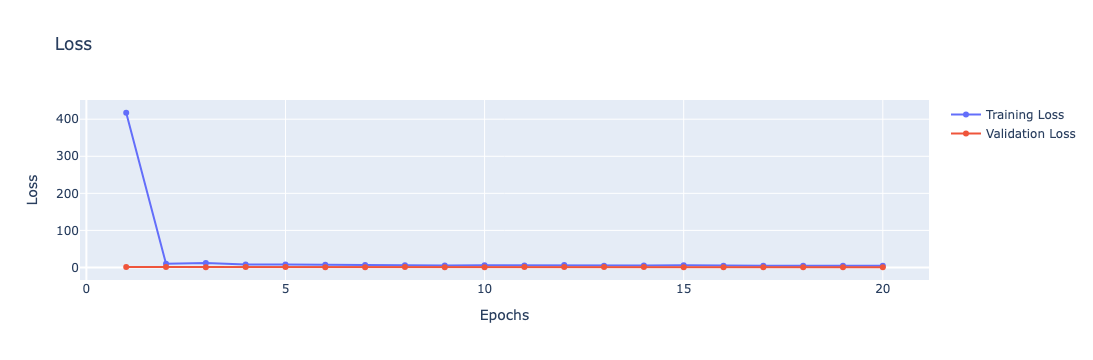

In [10]:
reg_trainer.mm.get_metric_chart("loss")

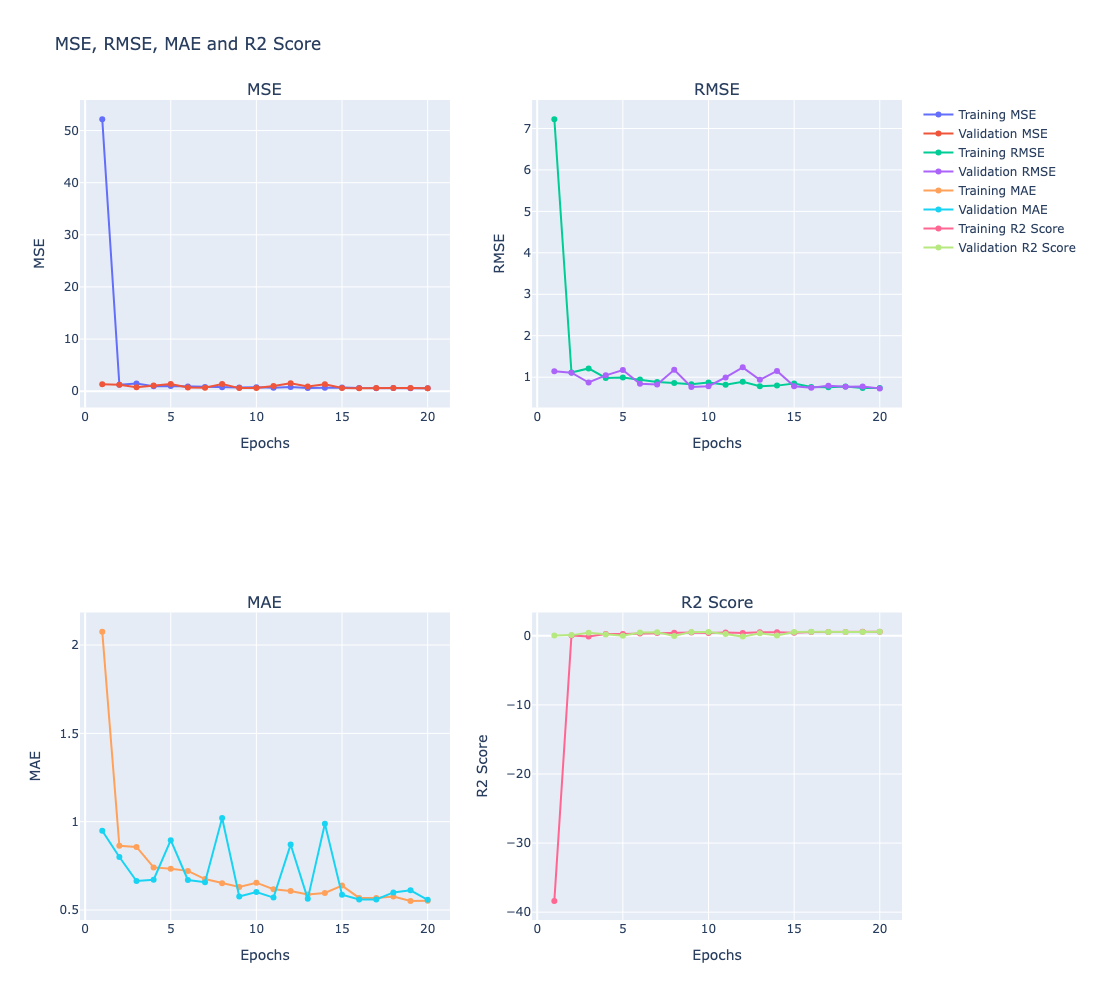

In [11]:
reg_trainer.mm.get_metric_chart_collection(["mse", "rmse", "mae", "r2"])

### Evaluating the Model on Test Data

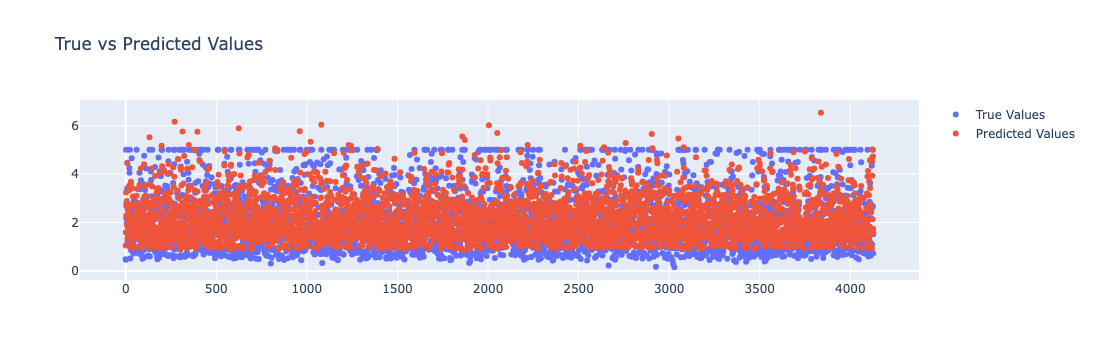

In [12]:
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

reg_model.eval()

with torch.no_grad():
    test_preds = reg_model(X_test)
    test_preds = test_preds.float().cpu().numpy().flatten()

x = np.arange(0, X_test.shape[0])
pp.plot_data(
    true_vals=pp.create_trace(x, y_test, name="True Values", mode="markers"),
    pred_vals=pp.create_trace(x, test_preds, name="Predicted Values", mode="markers"),
    title="True vs Predicted Values",
)

## Binary Classification

### Data Loading and Preprocessing

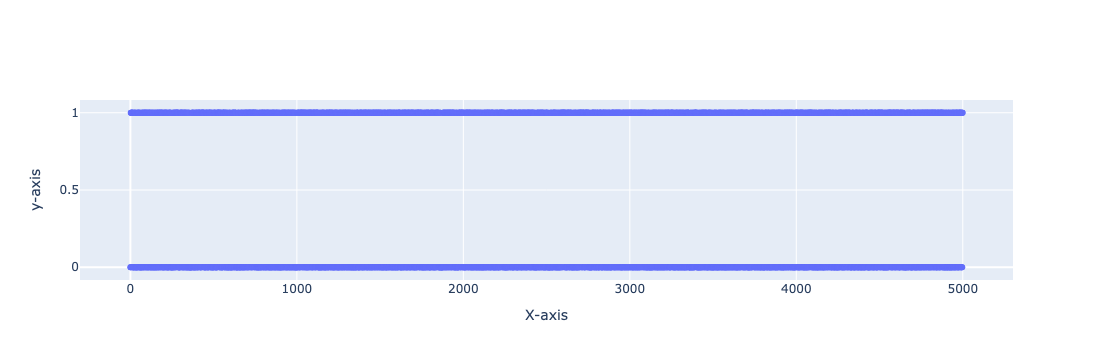

In [13]:
# # Get breast cancer data
# X, y = load_breast_cancer(return_X_y=True)
# x = np.arange(0, y.shape[0])
# pp.plot_data(x, y, x_label="X-axis", y_label="y-axis")

# Generate random data
X, y = make_classification(n_samples=5000, n_features=50, n_classes=2, n_informative=25)
x = np.arange(0, y.shape[0])
pp.plot_data(x, y, x_label="X-axis", y_label="y-axis")

In [14]:
# Dataloading parameters
batch_size = 8
test_size = 0.2
val_size = 0.2

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=42)

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (3200, 50)
y_train: (3200,)
X_val: (800, 50)
y_val: (800,)
X_test: (1000, 50)
y_test: (1000,)


In [15]:
# Get tensors and dataloaders
X_train, y_train, X_val, y_val = get_tensors(X_train, y_train, X_val, y_val)
train_loader, val_loader = get_data_loaders(X_train, y_train, X_val, y_val, batch_size)

### Building the Model

In [16]:
# Training parameters
num_train_epochs = 20
l_rate = 1e-03
pred_threshold = 0.5
loss_choice = "binary"
optim_choice = "adam"

# Create configuration for model layers
layer_config_1 = [ # a simple logistic regression model (a perceptron)
    (X_train.shape[1], None, None),
    (1, "sigmoid", None),
]

layer_config_2 = [ # a multi-layer perceptron
    (X_train.shape[1], None, None),
    (200, "relu", None),
    (300, "relu", None),
    (400, "relu", 0.1),
    (200, "relu", None),
    (1, "sigmoid", None),
]

# Initialise model
b_cls_model = MLP(layer_config=layer_config_2, model_name="BinClsModel")
b_cls_model.set_model_layers()

# Initialise model parameters
b_cls_model.apply(lambda m: param_init(m, "xavier"))

# Move model to selected device
b_cls_model.to(device)

print(b_cls_model)
print(f"Number of trainable parameters: {sum(p.numel() for p in b_cls_model.parameters())}")

MLP(
  (model): ModuleList(
    (0): Linear(in_features=50, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=400, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.1, inplace=False)
    (7): Linear(in_features=400, out_features=200, bias=True)
    (8): ReLU()
    (9): Linear(in_features=200, out_features=1, bias=True)
    (10): Sigmoid()
  )
)
Number of trainable parameters: 271301


### Training the Model

#### Loss Function and Optimiser

In [17]:
loss_fn = get_loss_fn(loss_choice)  # Binary cross-entropy loss because this a binary classification task
optimiser = get_optimiser(optim_choice, b_cls_model, l_rate) # adam

#### Training Loop

In [18]:
b_cls_trainer = MLPTrainer(type="cls", is_multiclass=False)

b_cls_trainer.train(
    b_cls_model,
    num_train_epochs,
    optimiser,
    loss_fn,
    train_loader,
    val_loader,
    pred_threshold=pred_threshold,
    device=device,
)

    |                       TRAINING SET                       ||                      VALIDATION SET                      |
    |   Loss   || Accuracy || Precison ||  Recall  ||    F1    ||   Loss   || Accuracy || Precison ||  Recall  ||    F1    |
001 | 2.12e+00 || 8.84e-01 || 8.88e-01 || 8.81e-01 || 8.84e-01 || 1.37e-01 || 9.45e-01 || 9.31e-01 || 9.59e-01 || 9.45e-01 |
002 | 9.03e-01 || 9.65e-01 || 9.66e-01 || 9.64e-01 || 9.65e-01 || 1.42e-01 || 9.65e-01 || 9.51e-01 || 9.80e-01 || 9.65e-01 |
003 | 6.36e-01 || 9.77e-01 || 9.77e-01 || 9.77e-01 || 9.77e-01 || 1.25e-01 || 9.63e-01 || 9.64e-01 || 9.59e-01 || 9.62e-01 |
004 | 4.66e-01 || 9.82e-01 || 9.83e-01 || 9.82e-01 || 9.82e-01 || 1.19e-01 || 9.70e-01 || 9.58e-01 || 9.82e-01 || 9.70e-01 |
005 | 4.59e-01 || 9.82e-01 || 9.83e-01 || 9.81e-01 || 9.82e-01 || 1.17e-01 || 9.69e-01 || 9.65e-01 || 9.72e-01 || 9.68e-01 |
006 | 2.79e-01 || 9.87e-01 || 9.89e-01 || 9.85e-01 || 9.87e-01 || 2.57e-01 || 9.61e-01 || 9.60e-01 || 9.62e-01 || 9.61e-01 |


#### Visualising Training Results

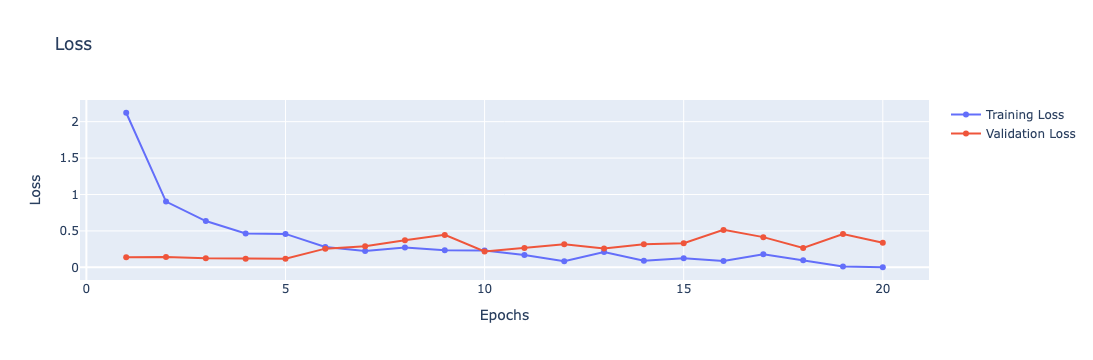

In [19]:
b_cls_trainer.mm.get_metric_chart("loss")

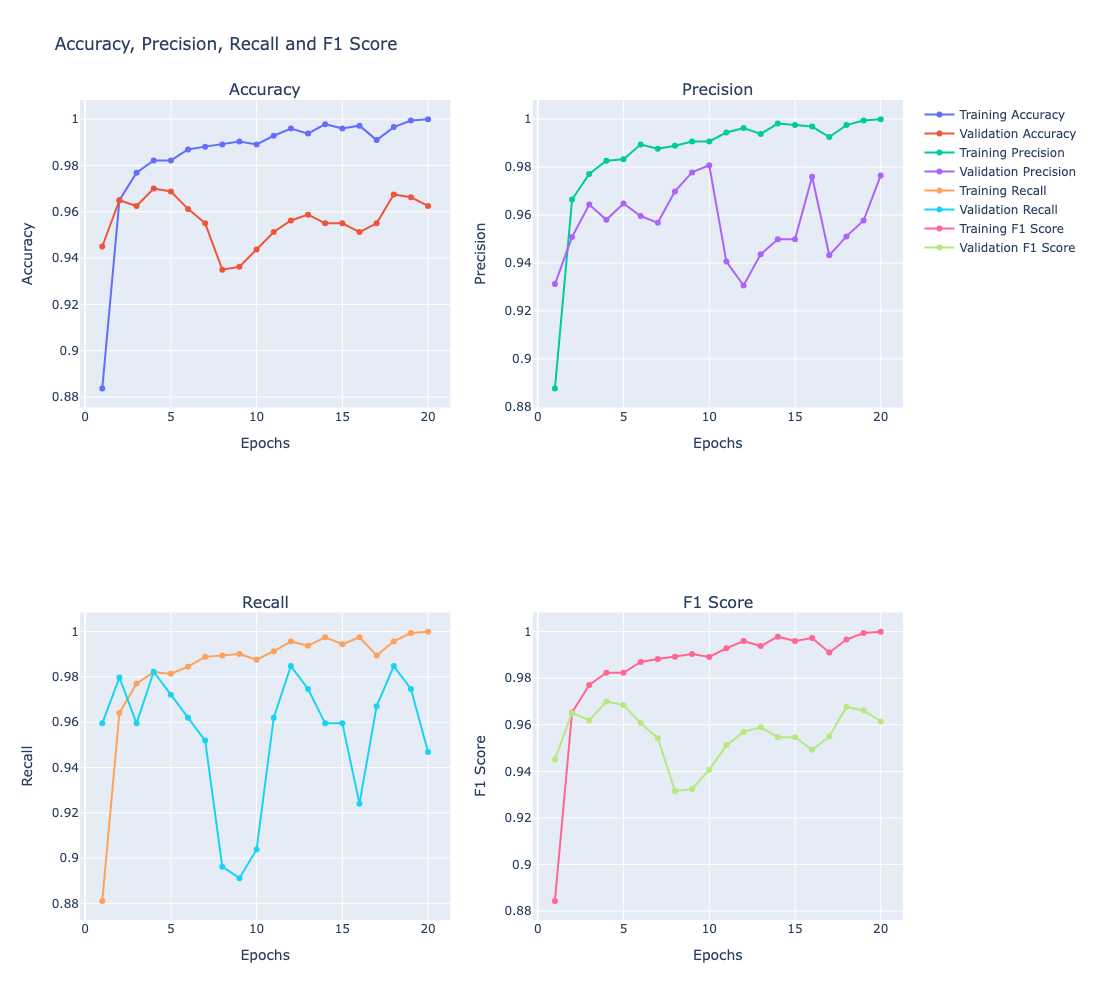

In [20]:
b_cls_trainer.mm.get_metric_chart_collection(["acc", "prec", "rec", "f1"])

### Evaluating the Model on Test Data

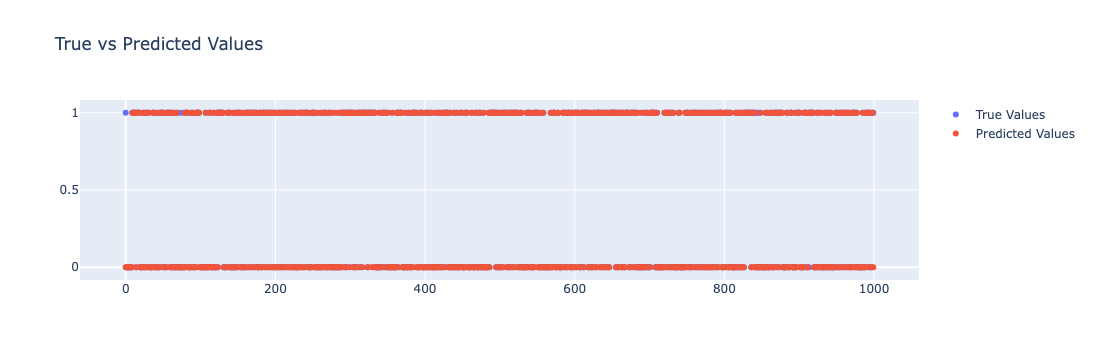

In [21]:
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

b_cls_model.eval()

with torch.no_grad():
    test_preds = b_cls_model(X_test)
    test_preds = (test_preds.detach().clone() > pred_threshold)
    test_preds = test_preds.float().cpu().numpy().flatten()

x = np.arange(0, X_test.shape[0])
pp.plot_data(
    true_vals=pp.create_trace(x, y_test, name="True Values", mode="markers"),
    pred_vals=pp.create_trace(x, test_preds, name="Predicted Values", mode="markers"),
    title="True vs Predicted Values",
)

In [22]:
# Test accuracy
test_acc = ((test_preds == y_test).sum() / y_test.shape[0]) 
print(f"Final accuracy: {test_acc * 100:.2f}%")

Final accuracy: 94.80%


## Multiclass Classification

### Data Loading and Preprocessing

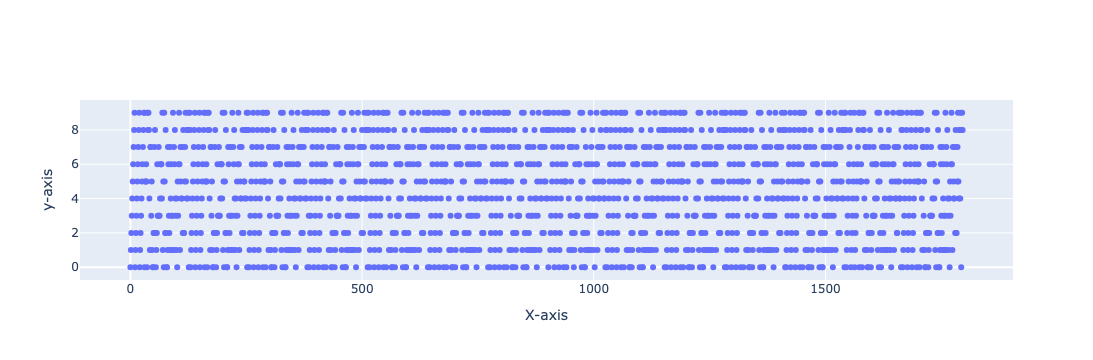

In [23]:
# Get digit image data
X, y = load_digits(return_X_y=True)
x = np.arange(0, y.shape[0])
pp.plot_data(x, y, x_label="X-axis", y_label="y-axis")

# # Generate random data
# X, y = make_classification(n_samples=5000, n_features=50, n_classes=3, n_informative=25)
# x = np.arange(0, y.shape[0])
# pp.plot_data(x, y, x_label="X-axis", y_label="y-axis")

In [24]:
# Dataloading parameters
batch_size = 8
test_size = 0.2
val_size = 0.2

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=42)

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (1149, 64)
y_train: (1149,)
X_val: (288, 64)
y_val: (288,)
X_test: (360, 64)
y_test: (360,)


In [25]:
# Get tensors and dataloaders
X_train, y_train, X_val, y_val = get_tensors(X_train, y_train, X_val, y_val)
train_loader, val_loader = get_data_loaders(X_train, y_train, X_val, y_val, batch_size)

### Building the Model

In [26]:
# Training parameters
num_train_epochs = 20
l_rate = 1e-03
loss_choice = "multiclass"
optim_choice = "adam"

# Create configuration for model layers
layer_config_1 = [ # a simple perceptron
    (X_train.shape[1], None, None),
    (np.unique(y).size, None, None),
]

layer_config_2 = [ # a multi-layer perceptron
    (X_train.shape[1], None, None),
    (200, "relu", None),
    (300, "relu", None),
    (400, "relu", 0.1),
    (200, "relu", None),
    (np.unique(y).size, None, None),
]

# Initialise model
m_cls_model = MLP(layer_config=layer_config_2, model_name="BinClsModel")
m_cls_model.set_model_layers()

# Initialise model parameters
m_cls_model.apply(lambda m: param_init(m, "xavier"))

# Move model to selected device
m_cls_model.to(device)

print(m_cls_model)
print(f"Number of trainable parameters: {sum(p.numel() for p in m_cls_model.parameters())}")

MLP(
  (model): ModuleList(
    (0): Linear(in_features=64, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=400, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.1, inplace=False)
    (7): Linear(in_features=400, out_features=200, bias=True)
    (8): ReLU()
    (9): Linear(in_features=200, out_features=10, bias=True)
  )
)
Number of trainable parameters: 275910


### Training the Model

#### Loss Function and Optimiser

In [27]:
loss_fn = get_loss_fn(loss_choice)  # Cross-entropy loss because this a multiclass classification task
optimiser = get_optimiser(optim_choice, m_cls_model, l_rate) # adam

#### Training Loop

In [28]:
m_cls_trainer = MLPTrainer(type="cls", is_multiclass=True)

m_cls_trainer.train(
    m_cls_model,
    num_train_epochs,
    optimiser,
    loss_fn,
    train_loader,
    val_loader,
    device=device,
)

    |                       TRAINING SET                       ||                      VALIDATION SET                      |
    |   Loss   || Accuracy || Precison ||  Recall  ||    F1    ||   Loss   || Accuracy || Precison ||  Recall  ||    F1    |
001 | 4.43e+00 || 8.33e-01 || 8.33e-01 || 8.33e-01 || 8.32e-01 || 2.64e-01 || 9.17e-01 || 9.24e-01 || 9.17e-01 || 9.16e-01 |
002 | 1.24e+00 || 9.46e-01 || 9.46e-01 || 9.46e-01 || 9.46e-01 || 1.75e-01 || 9.51e-01 || 9.61e-01 || 9.51e-01 || 9.52e-01 |
003 | 9.62e-01 || 9.67e-01 || 9.67e-01 || 9.67e-01 || 9.67e-01 || 1.92e-01 || 9.41e-01 || 9.45e-01 || 9.41e-01 || 9.40e-01 |
004 | 8.89e-01 || 9.65e-01 || 9.65e-01 || 9.65e-01 || 9.65e-01 || 1.65e-01 || 9.41e-01 || 9.46e-01 || 9.41e-01 || 9.41e-01 |
005 | 1.51e-01 || 9.93e-01 || 9.93e-01 || 9.93e-01 || 9.93e-01 || 8.88e-02 || 9.72e-01 || 9.74e-01 || 9.72e-01 || 9.72e-01 |
006 | 1.13e-01 || 9.96e-01 || 9.96e-01 || 9.96e-01 || 9.96e-01 || 1.98e-01 || 9.58e-01 || 9.62e-01 || 9.58e-01 || 9.59e-01 |


#### Visualising Training Results

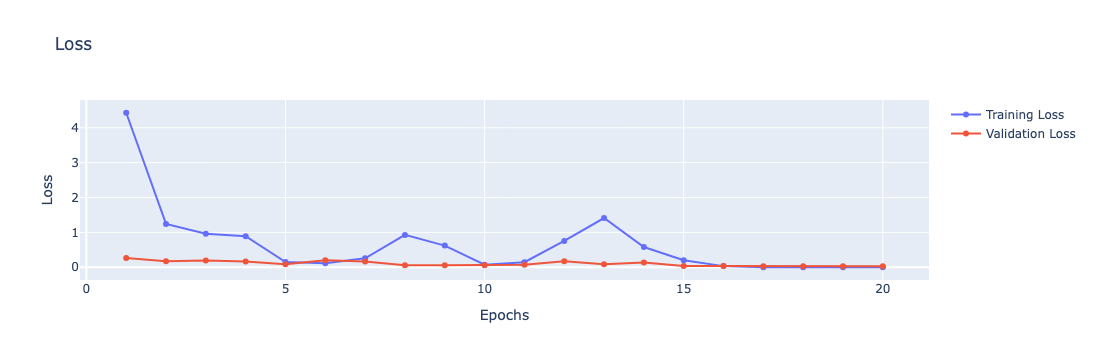

In [29]:
m_cls_trainer.mm.get_metric_chart("loss")

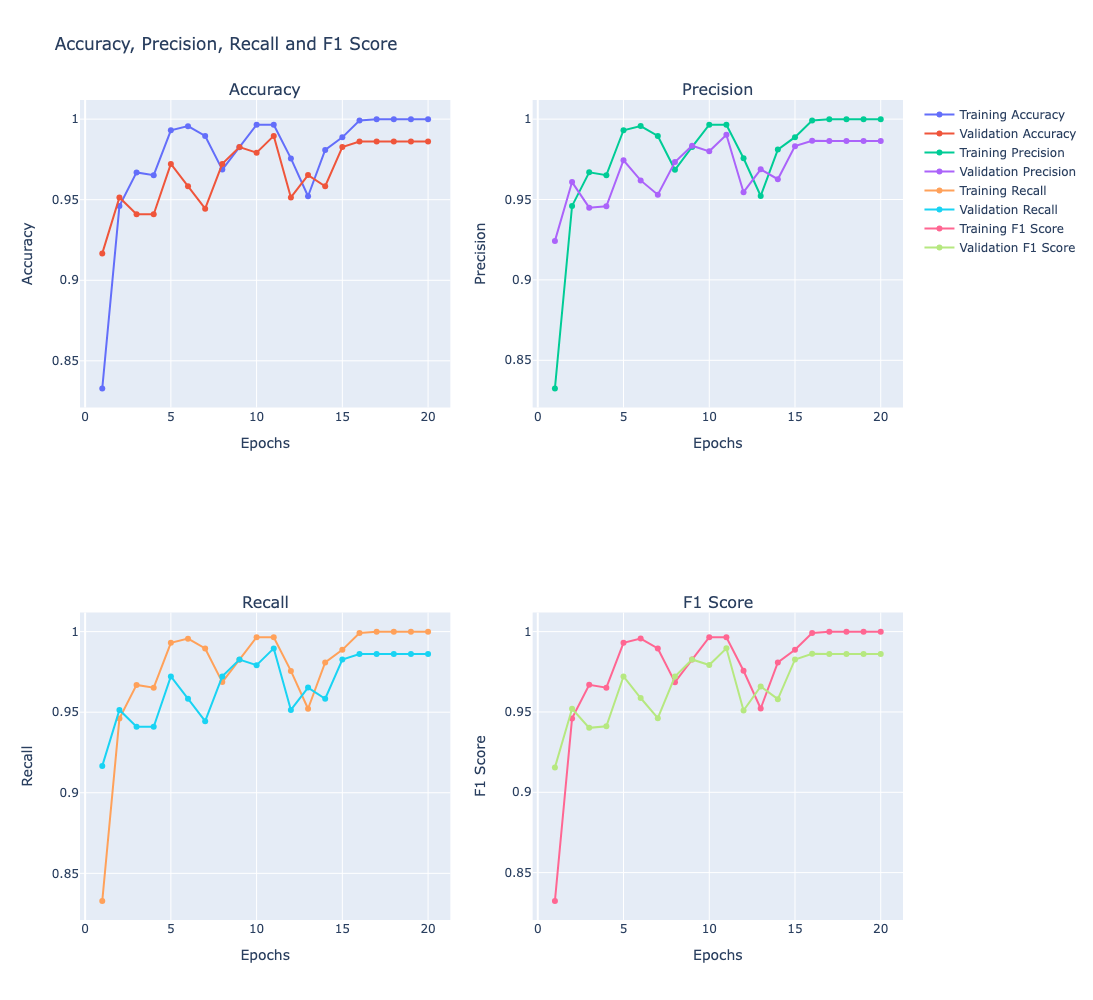

In [30]:
m_cls_trainer.mm.get_metric_chart_collection(["acc", "prec", "rec", "f1"])

### Evaluating the Model on Test Data

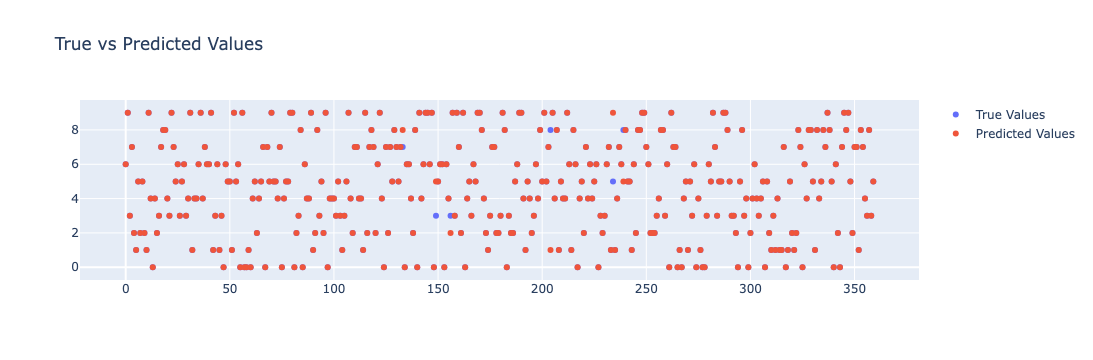

In [31]:
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

m_cls_model.eval()

with torch.no_grad():
    logits = m_cls_model(X_test)
    _, test_preds = torch.max(logits, 1)
    test_preds = test_preds.float().cpu().numpy().flatten()

x = np.arange(0, X_test.shape[0])
pp.plot_data(
    true_vals=pp.create_trace(x, y_test, name="True Values", mode="markers"),
    pred_vals=pp.create_trace(x, test_preds, name="Predicted Values", mode="markers"),
    title="True vs Predicted Values",
)

In [32]:
# Test accuracy
test_acc = ((test_preds == y_test).sum() / y_test.shape[0]) 
print(f"Final accuracy: {test_acc * 100:.2f}%")

Final accuracy: 98.33%
